---
**License**

 NC_ccl_xcor_gal_cmblensing

 Fri Mar 01 12:00:00 2024\
 Copyright  2024\
 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

---
---

 NC_ccl_xcor_gal_cmblensing\
 Copyright (C) 2024 Luigi Lucas de Carvalho Silva <luigi.lcsilva@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Startups and Packages

First of all, let us import some useful packages.

In [1]:
######## NUM COSMO ########
try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

######## CCL ########
import pyccl as pyccl

######## GENERAL ########
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

######## COMPARISSON ########
sys.path.append('/home/luigi/cosmology/NumCosmo/numcosmo_py/ccl/')

from nc_ccl import create_nc_obj
from nc_ccl import CCLParams

ccl_params_class = CCLParams()
ccl_cosmo_set_high_prec = ccl_params_class.set_high_prec_params


#create_nc_obj: Create a NumCosmo object from a CCL cosmology.
#ccl_cosmo_set_high_prec: Set CCL cosmology to high precision.

Now, let us get the libraries versions.

In [2]:
### GETTING NUMCOSMO VERSION
#dir(Ncm) # Show the library functions.

ncmpath = Ncm.__path__[0]
ncmpath = ncmpath.replace("/NumCosmoMath-1.0.typelib","")
buildfile = open(ncmpath+"/build_cfg.h", "r").readlines()

for line in buildfile:
    if "NUMCOSMO_VERSION" in line:
        ncversion=line
        for ch in ['#define','NUMCOSMO_VERSION','"','\n','  ']:
            if ch in ncversion:
                ncversion = ncversion.replace(ch,'')
print('NumCosmo Version: '+ncversion)
                
### GETTING CCL VERSION
print("CCL Version: "+str(pyccl.__version__))

NumCosmo Version: 0.22.0
CCL Version: 3.0.3.dev12+gaae09e9d.d20240717


Now, let us initialize the NumCosmo library.

In [3]:
Ncm.cfg_init ()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


## Cosmological parameters

In [4]:
# Fixed parameters.
Neff_massless_neutrinos = 3.0       # Effective number of massless neutrinos present. For the massive case, the Neff is
                                    # defined with the other parameters in the cosmology array.   
T_CMB = 2.726                       # The CMB temperature today. 

######### COSMOLOGIES ##########
#Reference: https://arxiv.org/pdf/1812.05995.pdf, Table 3 and Table 4.
#Order of parameters: Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu
CCL_cosmologies = {}
### MASSLESS NEUTRINOS ####
CCL_cosmologies["CCL1"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]  #flat ΛCDM
CCL_cosmologies["CCL2"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.0, Neff_massless_neutrinos, 0]  #wCDM
CCL_cosmologies["CCL3"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0 ]  #wCDM
#CCL_cosmologies["CCL4"] = [0.25, 0.05, 0.65, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #open wCDM    # Bad results for k different from 0.
#CCL_cosmologies["CCL5"] = [0.25, 0.05, 0.75, 0.7, 0.8, 0.96, -0.9, 0.1, Neff_massless_neutrinos, 0] #closed wCDM  # Bad results for k different from 0.
#CCL_cosmologies["CCL6"] = [0.3, 0.0, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, Neff_massless_neutrinos, 0]    #flat ΛCDM    # Kernel dying for this cosmology
CCL_cosmologies["WMAP7"] = [0.2265, 0.0455, 0.728, 0.704, 0.810, 0.967, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
CCL_cosmologies["Planck2013"] = [0.269, 0.0490, 0.682, 0.671, 0.834, 0.962, -1.0, 0.0, Neff_massless_neutrinos, 0] #flat ΛCDM
### MASSIVE NEUTRINOS ####
# Obs.: The create_nc_obj from nc_ccl.py is not updated for the new version of CCL. So, we cannot include massive neutrinos right now.
#CCL_cosmologies["CCL7"] = [0.25, 0.05, 0.7, 0.7, 0.8, 0.96, -1.0, 0.0, 3.013, [0.04,0,0]]  #flat ΛCDM, mν

names = []
for key, value in CCL_cosmologies.items():
    names.append(key)

# Defining the tracers

In [5]:
######## REDSHIFT DISTRIBUTION OF OBJECTS FROM HISTOGRAM ########
### Getting the redshift distribution for the objects from the CCL bin1_histo and bin2_histo files.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Loading the data. The txt files have 2 columns. The first column contains the redshift values, 
# and the second column contains the dndz values.
bin1_histo = np.loadtxt("./data/bin1_histo.txt", delimiter=" ") # Loading the first histogram.
len_bin1_histo = bin1_histo.shape[0] # Getting the number of lines.

bin2_histo = np.loadtxt("./data/bin2_histo.txt", delimiter=" ") # Loading the second histogram.
len_bin2_histo = bin2_histo.shape[0] # Getting the number of lines.

# Saving the redshift in two lists.
z_bin1_histo = []
z_bin2_histo = []

for i in range(len_bin1_histo):
    z_bin1_histo.append(bin1_histo[i][0])

for i in range(len_bin2_histo):
    z_bin2_histo.append(bin2_histo[i][0])

z_bin1_histo_np = np.array(z_bin1_histo)
z_bin2_histo_np = np.array(z_bin2_histo)

# Checking if the histograms have the same number of lines, and if the redshifts values are equal.
if len_bin1_histo != len_bin2_histo:
    print("Different histograms size!")
else:
    print("Equal histograms size! \n")
    z_histo_diff = [z_bin1_histo[i] - z_bin2_histo[i] for i in range(len_bin1_histo)]
    count_z_histo_diff_nonzero = np.count_nonzero(z_histo_diff)
    if count_z_histo_diff_nonzero == 0:
        print("Redshifts are also equal!")

# Saving the dndz values in two lists.
dndz_bin1_histo = []
dndz_bin2_histo = []
for i in range(len_bin1_histo):
    dndz_bin1_histo.append(bin1_histo[i][1])

for i in range(len_bin2_histo):
    dndz_bin2_histo.append(bin2_histo[i][1])

dndz_bin1_histo_np = np.array(dndz_bin1_histo)
dndz_bin2_histo_np = np.array(dndz_bin2_histo)

Equal histograms size! 

Redshifts are also equal!


In [6]:
######## ANALYTICAL REDSHIFT DISTRIBUTION OF OBJECTS ########
### Getting the analytical redshift distribution for the objects as used in CCL article.
# Source: https://github.com/LSSTDESC/CCL/tree/master/benchmarks/data -- Files bin1_histo.txt and bin2_histo.txt
# Used in the CCL article: https://arxiv.org/pdf/1812.05995.pdf

# Redshift values.
z_analytical_max = math.ceil(max(z_bin1_histo)) 
z_analytical = np.arange(0, z_analytical_max, 0.001)

# Below, I will multiply the gaussian distributions by the maximum value of the bin1_histo distribution, just for better visualization.
# The libraries used here do the normalization automatically.
peak_factor = max(dndz_bin1_histo)

# Analytical redshift distributions.
analytical_zmean_1 = 1.0
analytical_sigz_1 = 0.15
analytical_zmean_2 = 1.5
analytical_sigz_2 = 0.15
dndz_analytical_1 = peak_factor*np.exp(-0.5 * ((z_analytical - analytical_zmean_1) / analytical_sigz_1)**2)
dndz_analytical_2 = peak_factor*np.exp(-0.5 * ((z_analytical - analytical_zmean_2) / analytical_sigz_2)**2)

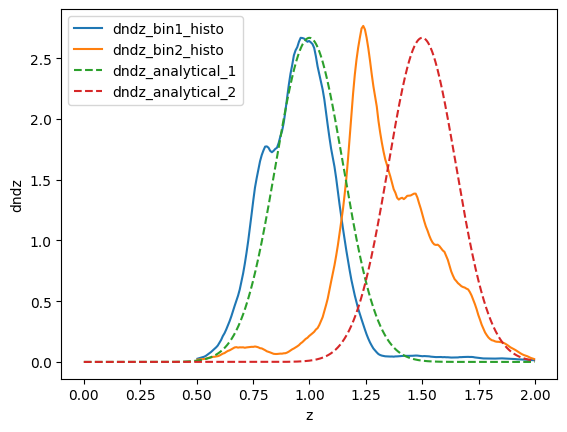

In [7]:
######## PLOT OF THE REDSHIFT DISTRIBUTIONS OF OBJECTS ########
plt.plot(z_bin1_histo, dndz_bin1_histo, label='dndz_bin1_histo')
plt.plot(z_bin2_histo, dndz_bin2_histo, label='dndz_bin2_histo')
plt.plot(z_analytical, dndz_analytical_1, label='dndz_analytical_1', linestyle='dashed')
plt.plot(z_analytical, dndz_analytical_2, label='dndz_analytical_2', linestyle='dashed')
plt.legend()
plt.xlabel('z')
plt.ylabel('dndz')
plt.show()

# Defining the function for the comparisson

In [8]:
# Obs.: Problem with the "mass_function" in the nc_ccl.py file. I commented it there.
def compare_galaxy_cmblens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z1, dndz1, z_lss, ells):
    """
    Compare the cross- angular power spectrum of galaxy and CMB Lensing.
    """
    ##### GENERAL #####
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ##### COSMOLOGIES #####
    # Defining the CCL cosmology.
    ccl_cosmo = pyccl.Cosmology(
        Omega_c=Omega_c, 
        Omega_b=Omega_b, 
        Neff=Neff,
        m_nu=m_nu,
        h=h, 
        n_s=n_s,
        Omega_k=Omega_k, 
        Omega_g=None,
        w0=w0, 
        wa=wa, 
        sigma8=sigma8,
        transfer_function='eisenstein_hu',
        T_CMB = T_CMB,
        matter_power_spectrum='linear',
    )
    # Setting CCL to high precision.
    ccl_cosmo_set_high_prec()

    # Defining the NumCosmo cosmology.
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)
    # More info: https://github.com/NumCosmo/NumCosmo/blob/master/numcosmo_py/ccl/nc_ccl.py

    ##### CCL POWER SPECTRUM COMPUTATION #####
    # Setting the galaxy bias to unity.
    unity_bias_1 = np.array([1 for i in np.arange(0, len(z1))])
   
    # Initialize tracers in CCL.
    trcs_ccl = dict()
    trcs_ccl['g1'] = pyccl.NumberCountsTracer(cosmo=ccl_cosmo, dndz=(z1, dndz1), bias=(z1, unity_bias_1), mag_bias=None, has_rsd=False)
    trcs_ccl['cmb1'] = pyccl.CMBLensingTracer(ccl_cosmo, z_source=z_lss)
    
    # Computing the angular power spectrum in CCL.    
    ccl_cl_cross = pyccl.angular_cl(ccl_cosmo, trcs_ccl['g1'], trcs_ccl['cmb1'], ells)
    #ccl_cl_auto1 = pyccl.angular_cl(ccl_cosmo, trcs_ccl['g1'], trcs_ccl['g1'], ells)
    #ccl_cl_auto2 = pyccl.angular_cl(ccl_cosmo, trcs_ccl['cmb1'], trcs_ccl['cmb1'], ells)

    # Converting the results to Numpy arrays.
    ccl_cl_cross_np = np.array(ccl_cl_cross)
    #ccl_cl_auto1_np = np.array(ccl_cl_auto1)
    #ccl_cl_auto2_np = np.array(ccl_cl_auto2)

    ##### NUMCOSMO POWER SPECTRUM COMPUTATION #####
    # Defining the z and dndz as vectors in NumCosmo.
    v_z1  = Ncm.Vector.new_array (z1)
    v_pz1 = Ncm.Vector.new_array (dndz1)

    # Obtaining the spline in NumCosmo.
    # Parameters Ncm.SplineCubicNotaknot.new_full:
    # xv: NcmVector of knots
    # yv: NcmVector of the values of the function, to be interpolated, computed at xv
    # init: TRUE to prepare the new NcmSpline or FALSE to not prepare it
    s_pz1 = Ncm.SplineCubicNotaknot.new_full (v_z1, v_pz1, True)

    ### Recombination by Seager
    recomb = Nc.RecombSeager()
    Nl_lensing = Ncm.Vector.new_array (np.zeros(lmax+1))
    #recomb.prepare (cosmo)
    
    # Defining the kernels in NumCosmo.
    nc_g1 = None
    nc_cmblens_1 = None
    ##### Nc.XcorLimberKernelGal.new:
    #zmin: a gdouble.
    #zmax: a gdouble.
    #np: number of points in the interpolation.
    #nbarm1: a gdouble, noise spectrum.
    #dn_dz: a NcmSpline.
    #dist: a NcDistance.
    #domagbias: whether to do magnification bias.
    ##### NcXcorLimberKernelCMBLensing.new:
    # Parameters
    #dist: a NcDistance
    #recomb: a NcRecomb
    #Nl: a NcmVector
    nc_g1 = Nc.XcorLimberKernelGal.new (z1[0], z1[-1], 1, 0.0, s_pz1, dist, False)
    nc_cmblens_1 = Nc.XcorLimberKernelCMBLensing.new (dist, recomb, Nl_lensing)

    # Pushing the objects to mset in NumCosmo.
    mset = Ncm.MSet.empty_new ()
    mset.set (cosmo)
    mset.push (nc_g1)
    mset.push (nc_cmblens_1)

    # Computing the angular power spectrum in NumCosmo.
    # Parameters nc_xcor_new:
    # nc_xcor_new (NcDistance *dist, NcmPowspec *ps, NcXcorLimberMethod meth);
    # Two methods are available to compute Limber-approximated integrals: independent GSL numerical integration or 
    # vector integration using Sundials's CVode algorithm.
    xcor = Nc.Xcor.new (dist, ps_lin, Nc.XcorLimberMethod.GSL)
    ####
    vp_cross = Ncm.Vector.new (lmax + 1)
    vp_auto1 = Ncm.Vector.new (lmax + 1)
    vp_auto2 = Ncm.Vector.new (lmax + 1)
    ####
    xcor.prepare (cosmo)
    ####
    # Parameters xcor.limber:
    # xc -> a NcXcor
    # xclk1 -> a NcXcorLimberKernel
    # xclk2 -> a NcXcorLimberKernel
    # cosmo -> a NcHICosmo
    # lmin -> a guint
    # lmax -> a guint
    # vp -> a NcmVector
    nc_g1.prepare (cosmo)
    nc_cmblens_1.prepare (cosmo)
    xcor.limber (nc_g1, nc_cmblens_1, cosmo, 0, lmax, vp_cross)
    xcor.limber (nc_g1, nc_g1, cosmo, 0, lmax, vp_auto1)
    xcor.limber (nc_cmblens_1, nc_cmblens_1, cosmo, 0, lmax, vp_auto2)

    # Getting the results and converting them to Numpy arrays.
    nc_cl_cross = [Ncm.Vector.get (vp_cross, i) for i in np.arange(0,lmax+1)]
    nc_cl_auto1 = [Ncm.Vector.get (vp_auto1, i) for i in np.arange(0,lmax+1)]
    nc_cl_auto2 = [Ncm.Vector.get (vp_auto2, i) for i in np.arange(0,lmax+1)]

    nc_cl_cross_np = np.array(nc_cl_cross)
    nc_cl_auto1_np = np.array(nc_cl_auto1)
    nc_cl_auto2_np = np.array(nc_cl_auto2)

    ##### RELATIVE DIFFERENCE COMPUTATION #####
    relative_diff_cross = (nc_cl_cross_np - ccl_cl_cross_np)/nc_cl_cross_np
    #relative_diff_auto1 = (nc_cl_auto1_np - ccl_cl_auto1_np)/nc_cl_auto1_np
    #relative_diff_auto2 = (nc_cl_auto2_np - ccl_cl_auto2_np)/nc_cl_auto2_np

    ### ACCURACY METRIC ###
    ## CROSS
    # Source: page 28, https://arxiv.org/pdf/1812.05995.pdf
    CCL_Cl_cross = ccl_cl_cross_np
    # For cross PS of fields a and b, we must have Caa, Cbb and Cab of the independent realization.
    # For auto PS of field a, Caa, Cbb and Cab can be set to the same value.
    Caa_cross = nc_cl_auto1_np
    Cbb_cross = nc_cl_auto2_np
    Cab_cross = nc_cl_cross_np
    grid_cross = np.indices(Cab_cross.shape)
    l_index_cross = grid_cross[0]

    intern_fact_cross = (Caa_cross*Cbb_cross + Cab_cross**2)/(2*l_index_cross+1)
    sig_l_cross = np.sqrt(intern_fact_cross)

    A_acc_cross = np.abs((CCL_Cl_cross - Cab_cross)/sig_l_cross)
    
    return ccl_cl_cross_np, nc_cl_cross_np, relative_diff_cross, A_acc_cross

# Doing the Galaxy-CMB Lensing comparisson for the histogram case

In [9]:
lmax=3000
ells = np.arange(lmax+1)

z1=z_bin1_histo_np
z2=z_bin2_histo_np
dndz1=dndz_bin1_histo_np
dndz2=dndz_bin2_histo_np

z_lss = 1090.0

/home/luigi/cosmology/CCL/pyccl/cells.py:68: CCLWarning: CCL does not properly use the hyperspherical Bessel functions when computing angular power spectra in non-flat cosmologies!
  warnings.warn(


[None]

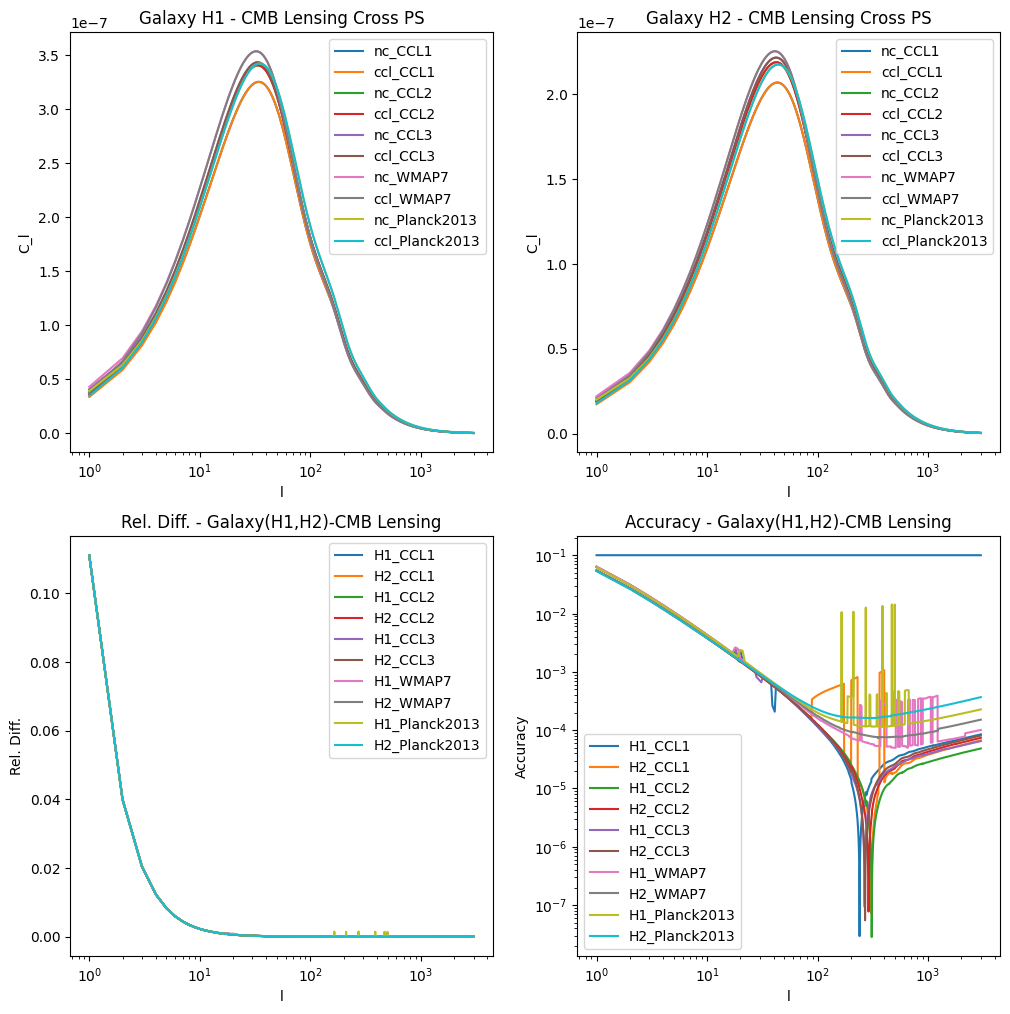

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

i=0
for cosmology in names:
    Omega_c = CCL_cosmologies[cosmology][0]
    Omega_b = CCL_cosmologies[cosmology][1]
    Omega_v = CCL_cosmologies[cosmology][2]
    h = CCL_cosmologies[cosmology][3]
    sigma8 = CCL_cosmologies[cosmology][4]
    n_s = CCL_cosmologies[cosmology][5]
    w0 = CCL_cosmologies[cosmology][6]
    wa = CCL_cosmologies[cosmology][7]
    Neff = CCL_cosmologies[cosmology][8]
    m_nu = CCL_cosmologies[cosmology][9]
        
    name=cosmology
    
    ccl_cl_cross_np_H1, nc_cl_cross_np_H1, relative_diff_cross_H1, A_acc_cross_H1 = \
    compare_galaxy_cmblens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z1, dndz1, z_lss, ells)

    ccl_cl_cross_np_H2, nc_cl_cross_np_H2, relative_diff_cross_H2, A_acc_cross_H2 = \
    compare_galaxy_cmblens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z2, dndz2, z_lss, ells)

    label_cross_nc_H1 = 'nc_'+name
    label_cross_ccl_H1 = 'ccl_'+name
    label_cross_rel_diff_H1 = 'H1_'+name
    label_cross_A_acc_H1 = 'H1_'+name

    label_cross_nc_H2 = 'nc_'+name
    label_cross_ccl_H2 = 'ccl_'+name
    label_cross_rel_diff_H2 = 'H2_'+name
    label_cross_A_acc_H2 = 'H2_'+name
     
    axs[0, 0].plot(ells[1:], nc_cl_cross_np_H1[1:], label=label_cross_nc_H1)
    axs[0, 0].plot(ells[1:], ccl_cl_cross_np_H1[1:], label=label_cross_ccl_H1)

    axs[0, 1].plot(ells[1:], nc_cl_cross_np_H2[1:], label=label_cross_nc_H2)
    axs[0, 1].plot(ells[1:], ccl_cl_cross_np_H2[1:], label=label_cross_ccl_H2)

    axs[1, 0].plot(ells[1:], relative_diff_cross_H1[1:], label=label_cross_rel_diff_H1)
    axs[1, 0].plot(ells[1:], relative_diff_cross_H2[1:], label=label_cross_rel_diff_H2)

    axs[1, 1].plot(ells[1:], A_acc_cross_H1[1:], label=label_cross_A_acc_H1)
    axs[1, 1].plot(ells[1:], A_acc_cross_H2[1:], label=label_cross_A_acc_H2)
    i+=1
    
axs[0, 0].set_title('Galaxy H1 - CMB Lensing Cross PS')
axs[0, 0].legend()
axs[0, 0].set(xlabel='l', ylabel='C_l')
axs[0, 0].set(xscale='log')

axs[0, 1].set_title('Galaxy H2 - CMB Lensing Cross PS')
axs[0, 1].legend()
axs[0, 1].set(xlabel='l', ylabel='C_l')
axs[0, 1].set(xscale='log')

axs[1, 0].set_title('Rel. Diff. - Galaxy(H1,H2)-CMB Lensing')
axs[1, 0].legend()
axs[1, 0].set(xlabel='l', ylabel='Rel. Diff.')
axs[1, 0].set(xscale='log')


expected_acc = np.empty(len(ells))
expected_acc.fill(0.1)

axs[1, 1].plot(ells[1:], expected_acc[1:])
axs[1, 1].set_title('Accuracy - Galaxy(H1,H2)-CMB Lensing')
axs[1, 1].legend()
axs[1, 1].set(xlabel='l', ylabel='Accuracy')
axs[1, 1].set(xscale='log')
axs[1, 1].set(yscale='log')

# Doing the Galaxy-CMB Lensing comparisson for the analytic case

In [11]:
lmax=3000
ells = np.arange(lmax+1)

z1=z_analytical
z2=z_analytical
dndz1=dndz_analytical_1
dndz2=dndz_analytical_2

z_lss = 1090.0

[None]

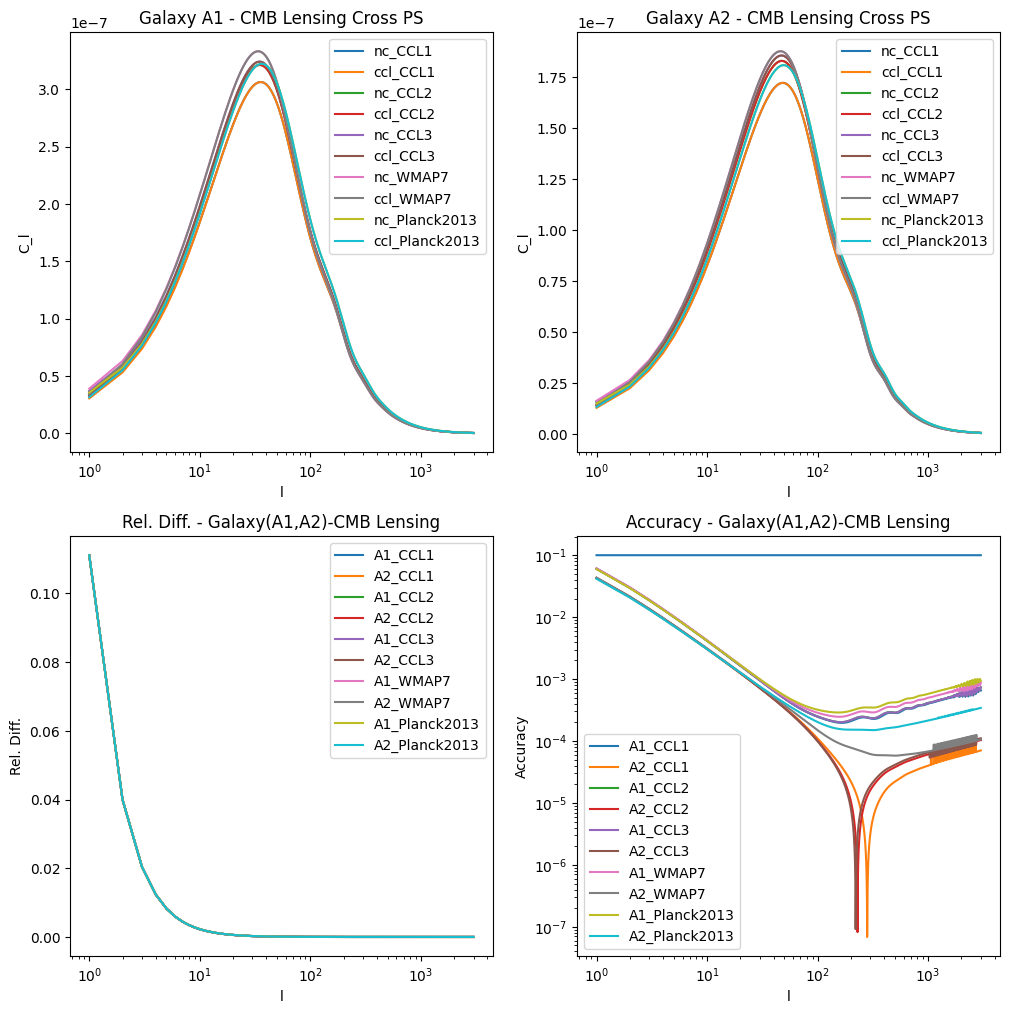

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

i=0
for cosmology in names:
    Omega_c = CCL_cosmologies[cosmology][0]
    Omega_b = CCL_cosmologies[cosmology][1]
    Omega_v = CCL_cosmologies[cosmology][2]
    h = CCL_cosmologies[cosmology][3]
    sigma8 = CCL_cosmologies[cosmology][4]
    n_s = CCL_cosmologies[cosmology][5]
    w0 = CCL_cosmologies[cosmology][6]
    wa = CCL_cosmologies[cosmology][7]
    Neff = CCL_cosmologies[cosmology][8]
    m_nu = CCL_cosmologies[cosmology][9]
        
    name=cosmology
    
    ccl_cl_cross_np_A1, nc_cl_cross_np_A1, relative_diff_cross_A1, A_acc_cross_A1 = \
    compare_galaxy_cmblens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z1, dndz1, z_lss, ells)

    ccl_cl_cross_np_A2, nc_cl_cross_np_A2, relative_diff_cross_A2, A_acc_cross_A2 = \
    compare_galaxy_cmblens_angular_cl(Omega_c, Omega_b, Omega_v, h, sigma8, n_s, w0, wa, Neff, m_nu, z2, dndz2, z_lss, ells)

    label_cross_nc_A1 = 'nc_'+name
    label_cross_ccl_A1 = 'ccl_'+name
    label_cross_rel_diff_A1 = 'A1_'+name
    label_cross_A_acc_A1 = 'A1_'+name

    label_cross_nc_A2 = 'nc_'+name
    label_cross_ccl_A2 = 'ccl_'+name
    label_cross_rel_diff_A2 = 'A2_'+name
    label_cross_A_acc_A2 = 'A2_'+name
     
    axs[0, 0].plot(ells[1:], nc_cl_cross_np_A1[1:], label=label_cross_nc_A1)
    axs[0, 0].plot(ells[1:], ccl_cl_cross_np_A1[1:], label=label_cross_ccl_A1)

    axs[0, 1].plot(ells[1:], nc_cl_cross_np_A2[1:], label=label_cross_nc_A2)
    axs[0, 1].plot(ells[1:], ccl_cl_cross_np_A2[1:], label=label_cross_ccl_A2)

    axs[1, 0].plot(ells[1:], relative_diff_cross_A1[1:], label=label_cross_rel_diff_A1)
    axs[1, 0].plot(ells[1:], relative_diff_cross_A2[1:], label=label_cross_rel_diff_A2)

    axs[1, 1].plot(ells[1:], A_acc_cross_A1[1:], label=label_cross_A_acc_A1)
    axs[1, 1].plot(ells[1:], A_acc_cross_A2[1:], label=label_cross_A_acc_A2)
    i+=1
    
axs[0, 0].set_title('Galaxy A1 - CMB Lensing Cross PS')
axs[0, 0].legend()
axs[0, 0].set(xlabel='l', ylabel='C_l')
axs[0, 0].set(xscale='log')

axs[0, 1].set_title('Galaxy A2 - CMB Lensing Cross PS')
axs[0, 1].legend()
axs[0, 1].set(xlabel='l', ylabel='C_l')
axs[0, 1].set(xscale='log')

axs[1, 0].set_title('Rel. Diff. - Galaxy(A1,A2)-CMB Lensing')
axs[1, 0].legend()
axs[1, 0].set(xlabel='l', ylabel='Rel. Diff.')
axs[1, 0].set(xscale='log')


expected_acc = np.empty(len(ells))
expected_acc.fill(0.1)

axs[1, 1].plot(ells[1:], expected_acc[1:])
axs[1, 1].set_title('Accuracy - Galaxy(A1,A2)-CMB Lensing')
axs[1, 1].legend()
axs[1, 1].set(xlabel='l', ylabel='Accuracy')
axs[1, 1].set(xscale='log')
axs[1, 1].set(yscale='log')